## Importação dos pacotes

In [2]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [3]:
# definir parâmetros extras
#pd.set_option('precision', 2)
pd.set_option('display.max_columns', 100)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# importar pacotes usados na seleção do modelo e na medição da precisão
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# importar os pacotes necessários para os algoritmos de regressão
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

## Carga dos dados de entrada

In [6]:
# carregar arquivo de dados de treino
filename = 'weather-train.csv'
#filename = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-abalone/abalone-train.csv'
data = pd.read_csv(filename, index_col='date', parse_dates=['date'])

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.head()

(1508, 3)


,temperature,humidity,wind_speed
date,,,
2012-10-01,11.036840,74.800000,0.000000
2012-10-02,14.340558,58.444444,0.666667
2012-10-03,14.518382,78.555556,1.888889
2012-10-04,16.820351,86.000000,1.333333
2012-10-05,16.948431,70.555556,3.666667


In [7]:
#data.dropna(inplace=True)
data.dropna(axis=0, how='any', inplace=True)

In [8]:
# definir dados de entrada
X = data.drop(['temperature'], axis=1) # tudo, exceto a coluna alvo
y = data['temperature'] # apenas a coluna alvo

print('Forma dos dados originais:', X.shape, y.shape)

Forma dos dados originais: (1507, 2) (1507,)


## Treinamento dos modelos preditivos

In [9]:
from sklearn.metrics import make_scorer, mean_squared_error

# cria função para cálculo do RMSE (REMQ)
def root_mean_squared_error(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(root_mean_squared_error, greater_is_better=False)

In [67]:
from sklearn.metrics import SCORERS
#sorted(SCORERS.keys())
MAE = 'neg_mean_absolute_error'

In [68]:
from datetime import datetime

# avalia o desempenho do modelo, retornando o valor do RMSE
def evaluate_model_cv(model, X=X, y=y):
    start = datetime.now()
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_val_score(model, X, y, cv=kfold, scoring=MAE, verbose=1)
    #results = cross_val_score(model, X, y, cv=kfold, scoring=RMSE, verbose=1)
    end = datetime.now()
    elapsed = int((end - start).total_seconds() * 1000)
    score = (-1) * results.mean()
    stddev = results.std()
    print(model, '\nScore: %.2f (+/- %.2f) [%5s ms]' % (score, stddev, elapsed))
    return score, stddev, elapsed

In [69]:
# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X=X, y=y):
  print('\nFine Tuning Model:')
  print(model, "\nparams:", params)
  kfold = KFold(n_splits=10, random_state=42)
  grid = GridSearchCV(estimator=model, param_grid=params, scoring=MAE, cv=kfold, verbose=1)
  #grid = GridSearchCV(estimator=model, param_grid=params, scoring=RMSE, cv=kfold, verbose=1)
  grid.fit(X, y)
  print('\nGrid Best Score: %.2f' % (grid.best_score_ * (-1)))
  print('Best Params:', grid.best_params_)
  return grid

## Avaliação e ajuste fino de cada modelo preditivo

- https://scikit-learn.org/stable/modules/classes.html
- https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html

### Generalized Linear Models

In [70]:
model = LinearRegression(n_jobs=-1, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = dict(
    fit_intercept=[True, False],
    normalize=[True, False]
)
fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True) 
Score: 10.32 (+/- 2.61) [  341 ms]

Fine Tuning Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True) 
params: {'fit_intercept': [True, False], 'normalize': [True, False]}
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Grid Best Score: 10.32
Best Params: {'fit_intercept': True, 'normalize': True}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.2s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [71]:
model = OrthogonalMatchingPursuit(fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = dict(
    n_nonzero_coefs=[None, 1, 2, 5, 7],
    fit_intercept=[True, False],
    normalize=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
             normalize=True, precompute='auto', tol=None) 
Score: 10.20 (+/- 2.54) [  262 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [72]:
model = PassiveAggressiveRegressor(random_state=42, C=0.1, fit_intercept=True, max_iter=1000, tol=0.001)
evaluate_model_cv(model)

params = {
    'C': [0.1, 0.2, 0.4, 0.8, 1.0],
    'fit_intercept': [True, False],
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


PassiveAggressiveRegressor(C=0.1, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=1000, n_iter=None, n_iter_no_change=5,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 13.80 (+/- 7.35) [  323 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [73]:
model = RANSACRegressor(random_state=42, min_samples=0.75)
evaluate_model_cv(model)

#base_estimator=None, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None,
#max_trials=100, max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss=’absolute_loss’,
#random_state=None

params = {
    'min_samples': [None, 0.1, 0.25, 0.5, 0.75, 1.0]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=0.75, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 10.55 (+/- 2.84) [ 7681 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished


In [74]:
model = Ridge(random_state=42, alpha=0.001, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

#alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’,
#random_state=None

params = {
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=42, solver='auto', tol=0.001) 
Score: 10.32 (+/- 2.61) [  284 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [75]:
model = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)
evaluate_model_cv(model)

#loss=’squared_loss’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001,
#shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate=’invscaling’, eta0=0.01, power_t=0.25,
#early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False) 
Score: 942148954292.23 (+/- 594679127202.16) [ 1681 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [76]:
model = TheilSenRegressor(random_state=42, n_jobs=-1, fit_intercept=True)
evaluate_model_cv(model)

#fit_intercept=True, copy_X=True, max_subpopulation=10000.0, n_subsamples=None, 
#max_iter=300, tol=0.001, random_state=None, n_jobs=None, verbose=False

params = {
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
         random_state=42, tol=0.001, verbose=False) 
Score: 10.39 (+/- 2.96) [53517 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   53.5s finished


### Decision Trees

In [77]:
model = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)
evaluate_model_cv(model)

#criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, presort=False

params = dict(
    max_depth=[4, 6, 8, 10, 12, 14],
    min_samples_split=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.25, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best') 
Score: 10.31 (+/- 2.48) [  296 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


### Gaussian Processes

In [78]:
model = GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=False)
evaluate_model_cv(model)

#kernel=None, alpha=1e-10, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0,
#normalize_y=False, copy_X_train=True, random_state=None

params = dict(
    alpha=np.logspace(-6, -1, 6),
    normalize_y=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 11.52 (+/- 2.57) [24700 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.7s finished


### Kernel Ridge Regression

In [79]:
model = KernelRidge(alpha=0.1)
evaluate_model_cv(model)

#alpha=1, kernel=’linear’, gamma=None, degree=3, coef0=1, kernel_params=None

params = dict(
    alpha=np.logspace(-6, -1, 6)
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None) 
Score: 10.40 (+/- 2.68) [11561 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.6s finished


### Naïve Bayes

### Nearest Neighbors

In [80]:
model = KNeighborsRegressor(n_jobs=-1, n_neighbors=11, weights='distance')
evaluate_model_cv(model)

#n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’,
#metric_params=None, n_jobs=None

params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
          weights='distance') 
Score: 10.70 (+/- 2.57) [  636 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


### Support Vector Machines

In [81]:
model = SVR(gamma='auto', kernel='linear')
evaluate_model_cv(model)

#kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, 
#epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 10.53 (+/- 2.97) [ 9574 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished


### Neural network models

In [82]:
model = MLPRegressor(random_state=42, max_iter=500,
                     activation='tanh', hidden_layer_sizes=(5, 2), solver='lbfgs')
evaluate_model_cv(model)

#hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, 
#learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
#random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10

params = dict(
    hidden_layer_sizes=[(100,), (50,), (50,2)],
    activation=['identity', 'logistic', 'tanh', 'relu'],
    solver=['lbfgs', 'sgd', 'adam']
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 10.32 (+/- 2.61) [ 1238 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


### Ensemble Methods

In [83]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=9)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
#verbose=0, warm_start=False

params = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_depth': [None, 3, 5, 7, 9, 11, 13]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 10.38 (+/- 2.51) [13020 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.0s finished


In [84]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.8, max_depth=6, max_features=0.75)
evaluate_model_cv(model)

#loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2,
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, 
#max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, 
#tol=0.0001

params = dict(
    n_estimators=[100, 250, 500],
    max_features=[0.75, 0.85, 1.0],
    max_depth=[4, 6, 8, 10],
    learning_rate=[0.05, 0.1, 0.15],
    subsample=[0.4, 0.6, 0.8]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6, max_features=0.75,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 10.39 (+/- 2.51) [ 4981 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.0s finished


In [85]:
model = ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=200, max_features=0.75)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0,
#warm_start=False

params = dict(
    n_estimators=[50, 75, 100, 200],
    max_features=['auto', 0.75, 0.85, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.75, max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
          oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 11.17 (+/- 2.22) [27874 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.9s finished


In [86]:
model = BaggingRegressor(random_state=42, n_jobs=-1, base_estimator=DecisionTreeRegressor(),
                        max_features=0.75, n_estimators=75)
evaluate_model_cv(model)

#base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, 
#bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0

params = dict(
    n_estimators=[50, 75, 100, 200],
    max_features=[0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.75,
         max_samples=1.0, n_estimators=75, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False) 
Score: 10.53 (+/- 2.65) [ 9676 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.7s finished


In [87]:
model = AdaBoostRegressor(random_state=42, n_estimators=200, base_estimator=DecisionTreeRegressor())
evaluate_model_cv(model)

# base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None

params = dict(
    n_estimators=[50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=200,
         random_state=42) 
Score: 11.06 (+/- 2.21) [23436 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.4s finished


### Outros algoritmos

#### XGBoost

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [88]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1,
                     n_estimators=50, max_depth=5, objective='reg:squarederror')
evaluate_model_cv(model)

#max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror',
#booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
#colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
#base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

params = dict(
    max_depth=[3, 5, 7, 9],
    n_estimators=[50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futur

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1) 
Score: 10.43 (+/- 2.56) [ 4128 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


### Ensemble Learning Model

- https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e
- https://github.com/vecxoz/vecstack

In [29]:
# https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a

# classe não disponível no pacote :P
#from sklearn.ensemble import VotingRegressor
#conda update scikit-learn
#pip install -U scikit-learn

estimators =  [
    ('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='tanh', hidden_layer_sizes=(5, 2), solver='lbfgs')),
    ('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=False)),
    ('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.8, max_depth=6, max_features=0.75))
    #('RFR', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=7)),
    #('ETR', ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=100)),
    #('XGBR', XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1,
    #             n_estimators=50, max_depth=5, objective='reg:squarederror'))
]

model = VotingRegressor(estimators, n_jobs=-1, weights=(2,1,1))
evaluate_model_cv(model)

#estimators, weights=None, n_jobs=None

params = dict(
    weights=[(1,1,1), (5,4,3), (2,1,1), (3,2,1)]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


VotingRegressor(estimators=[('MLP',
                             MLPRegressor(activation='tanh', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(5, 2),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_iter=500, momentum=0.9,
                                          n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_state=42, shuffle=True,
                                          solver='...
                                                       loss='ls', max_depth=6,
                                                       ma

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s finished


## Comparação final entre os algoritmos

In [32]:
models = []

# Generalized Linear Models
models.append(('LinReg', LinearRegression(n_jobs=-1, fit_intercept=True, normalize=True)))
models.append(('LogReg', LogisticRegression(n_jobs=-1, random_state=42, multi_class='auto', C=1000, solver='newton-cg')))
models.append(('OMP', OrthogonalMatchingPursuit(n_nonzero_coefs=7, fit_intercept=True, normalize=True)))
models.append(('PAR', PassiveAggressiveRegressor(random_state=42, C=0.1, fit_intercept=True, max_iter=1000, tol=0.001)))
models.append(('PP', Perceptron(random_state=42, penalty='l2', alpha=1e-3, fit_intercept=True, max_iter=1000, tol=1e-3)))
models.append(('RANSAC', RANSACRegressor(random_state=42, min_samples=0.75)))
models.append(('Ridge', Ridge(random_state=42, alpha=0.001, fit_intercept=True, normalize=True)))
models.append(('SGD', SGDRegressor(random_state=42, alpha=1e-6, fit_intercept=True, penalty=None, tol=1e-3)))
models.append(('TSR', TheilSenRegressor(random_state=42, n_jobs=-1, fit_intercept=True)))

# Decision Trees
models.append(('DTR', DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)))

# Gaussian Processes
models.append(('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=False)))

# Kernel Ridge Regression
models.append(('KRR', KernelRidge(alpha=0.1)))

# Naïve Bayes
models.append(('GNB', GaussianNB(var_smoothing=0.001)))

# Nearest Neighbors
models.append(('kNN', KNeighborsRegressor(n_jobs=-1, n_neighbors=11, weights='distance')))

# Support Vector Machines
models.append(('SVM', SVR(gamma='auto', kernel='linear')))

# Neural network models
models.append(('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='tanh', hidden_layer_sizes=(5, 2), solver='lbfgs')))

# Ensemble Methods
models.append(('RFR', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=9)))
models.append(('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.8, max_depth=6, max_features=0.75)))
models.append(('ETR', ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=200, max_features=0.75)))
models.append(('BDTR', BaggingRegressor(random_state=42, n_jobs=-1, base_estimator=DecisionTreeRegressor(),
                                       max_features=0.75, n_estimators=75)))
models.append(('ABDTR', AdaBoostRegressor(random_state=42, n_estimators=200, base_estimator=DecisionTreeRegressor())))

# XGBoost
models.append(('XGBR', XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1,
                                    n_estimators=50, max_depth=5, objective='reg:squarederror')))

# Voting
models.append(('VR', VotingRegressor(estimators=[
    ('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='tanh', hidden_layer_sizes=(5, 2), solver='lbfgs')),
    ('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=False)),
    ('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.8, max_depth=6, max_features=0.75))
], n_jobs=-1, weights=(2,1,1))))

In [33]:
results = []
names = []
scores = []
stddevs = []
times = []

for name, model in models:
    score, stddev, elapsed = evaluate_model_cv(model, X=X, y=y)
    results.append((score, stddev))
    names.append(name)
    scores.append(score)
    stddevs.append(stddev)
    times.append(elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True) 
Score: 2.21 (+/- 0.17) [   25 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False) 
Score: 2.46 (+/- 0.22) [23008 ms]
OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=7, normalize=True,
                          precompute='auto', tol=None) 
Score: 2.21 (+/- 0.17) [   20 ms]
PassiveAggressiveRegressor(C=0.1, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=42, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Score: 2.29 (+/- 0.25) [   36 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=0.001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 3.07 (+/- 0.31) [  193 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=0.75, random_state=42, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 2.23 (+/- 0.19) [  621 ms]
Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=42, solver='auto', tol=0.001) 
Score: 2.21 (+/- 0.18) [   18 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False) 
Score: 2.28 (+/- 0.21) [  524 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
                  random_state=42, tol=0.001, verbose=False) 
Score: 2.22 (+/- 0.16) [ 4667 ms]
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.25, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best') 
Score: 2.50 (+/- 0.22) [   35 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 2.13 (+/- 0.17) [ 2347 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None) 
Score: 2.21 (+/- 0.17) [ 1163 ms]
GaussianNB(priors=None, var_smoothing=0.001) 
Score: 5.35 (+/- 0.47) [   38 ms]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                    weights='distance') 
Score: 2.24 (+/- 0.20) [  144 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.34 (+/- 0.23) [ 2198 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 2.10 (+/- 0.16) [ 2428 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False) 
Score: 2.18 (+/- 0.20) [ 4062 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=6,
                          max_features=0.75, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.17 (+/- 0.19) [ 1858 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features=0.75, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False) 
Score: 2.23 (+/- 0.19) [ 4571 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=0.75,
                 max_sampl

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=200,
                  rand

/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1) 
Score: 2.21 (+/- 0.20) [  324 ms]
VotingRegressor(estimators=[('MLP',
                             MLPRegressor(activation='tanh', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(5, 2),
                                          learning_rate='constant',
                    

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


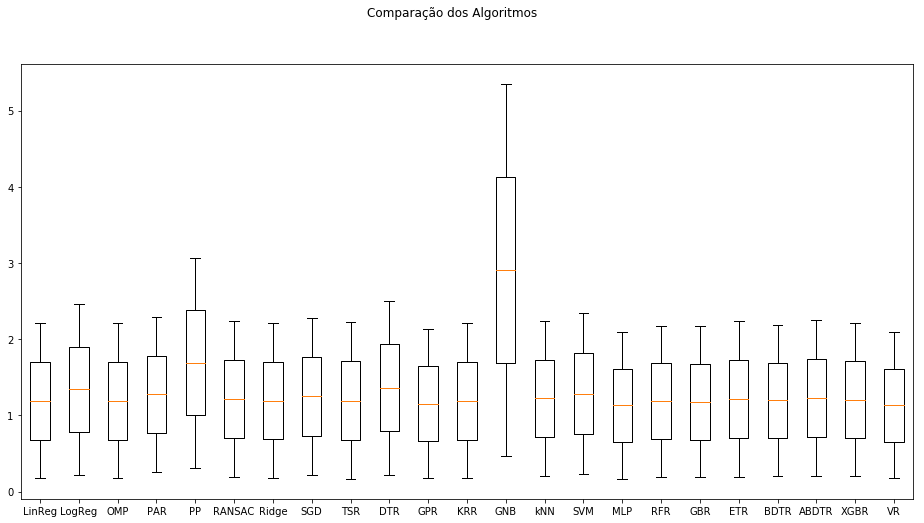

In [34]:
# comparar desempenhos dos algoritmos
fig = plt.figure(figsize=(16,8))
fig.suptitle('Comparação dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [35]:
results_df = pd.DataFrame({'Model': names, 'Score': scores, 'Std Dev': stddevs, 'Time (ms)': times})
results_df.sort_values(by='Score', ascending=True)

,Model,Score,Std Dev,Time (ms)
22,VR,2.089943,0.176079,6617
15,MLP,2.097064,0.164217,2428
10,GPR,2.132577,0.174771,2347
17,GBR,2.169043,0.185749,1858
16,RFR,2.176777,0.195910,4062
19,BDTR,2.187452,0.204435,1591
2,OMP,2.205400,0.171963,20
6,Ridge,2.206863,0.175725,18
11,KRR,2.207157,0.173504,1163
0,LinReg,2.207549,0.171718,25
